# 322 Project Exploratory Data Analysis

In [323]:
import importlib
import random

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.plot_utils 
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plotutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MySimpleLinearRegressor, MyNaiveBayesClassifier, MyDecisionTreeClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

In [324]:
customerData = MyPyTable()
customerData.load_from_file('projectData/test.csv')
customerData.remove_rows_with_missing_values()

# get rid of # and ID columns
newTable = []
for row in customerData.data:
    newTable.append(row[2:])
customerData.data = newTable
customerData.column_names = customerData.column_names[2:]


## Random Subsampling

In [325]:
indices = list(range(len(customerData.data)))
random.shuffle(indices)
subset = indices[0:1000]
newTable = []
for ind in subset:
    newTable.append(customerData.data[ind])
customerData.data = newTable

satisfaction = []
for row in customerData.data:
    satisfaction.append(row.pop())



## Categorizing Flight Distance

In [326]:
distance = myutils.get_column(customerData.data, customerData.column_names, 'Flight Distance')
distCutoffs = myutils.compute_equal_width_cutoffs(distance, 5)
distBins = myutils.convert_cutoffs_to_bins(distCutoffs)
for i in range(len(customerData.data)):
    customerData.data[i][5] = myutils.convertBinToCategory(customerData.data[i][5], distBins)

## Categorizing Age

In [327]:
age = myutils.get_column(customerData.data, customerData.column_names, 'Age')
ageCutoffs = myutils.compute_equal_width_cutoffs(age, 5)
ageBins = myutils.convert_cutoffs_to_bins(ageCutoffs)
for i in range(len(customerData.data)):
    customerData.data[i][2] = myutils.convertBinToCategory(customerData.data[i][2], ageBins)

# Exploratory Data Analysis

## Overall Satisfaction

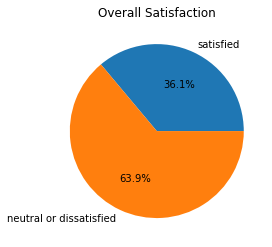

In [341]:
totSatisfied = 0

for val in satisfaction:
    if val == 'satisfied':
        totSatisfied += 1
plotutils.plot_pie_chart(['satisfied', 'neutral or dissatisfied'], [totSatisfied, len(satisfaction) - totSatisfied], 'Overall Satisfaction')

## Gender and Customer Satisfaction

In [342]:
genders = myutils.get_column(customerData.data, customerData.column_names, 'Gender')

totalMale = 0
totalFemale = 0
maleCount = 0
femaleCount = 0

for i in range(len(customerData.data)):
    if customerData.data[i][0] == 'Male':
        totalMale += 1
        if satisfaction[i] == 'satisfied':
            maleCount += 1
    if customerData.data[i][0] == 'Female':
        totalFemale += 1
        if satisfaction[i] == 'satisfied':
            femaleCount += 1

### Gender Distribution

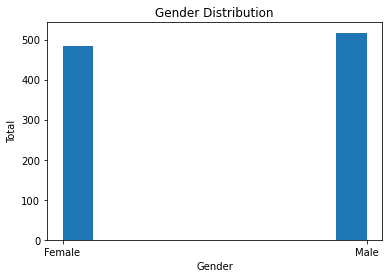

In [339]:
plotutils.plot_histogram(genders, 'Gender Distribution', 'Gender', 'Total')

### Male Flight Satisfaction

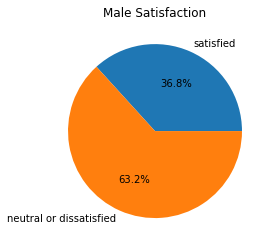

In [336]:
plotutils.plot_pie_chart(['satisfied', 'neutral or dissatisfied'], [maleCount, totalMale - maleCount], 'Male Satisfaction')


### Female Flight Satisfaction

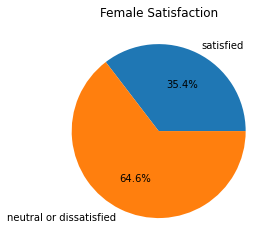

In [337]:
plotutils.plot_pie_chart(['satisfied', 'neutral or dissatisfied'], [femaleCount, totalFemale - femaleCount], 'Female Satisfaction')

There is a seemingly even distribution of males and females in the dataset, and they both have similar levels of satisfaction.

In [315]:
k = 10

xTrainInd, xTestInd = myevaluation.stratified_kfold_cross_validation(customerData.data, satisfaction, k)
#print(xTestInd)

for i in range(1):
    xTrain = []
    yTrain = []
    xTest = []
    yTest = []

    satTree = MyDecisionTreeClassifier()

    for val in xTrainInd[i]:
        xTrain.append(customerData.data[val])
        yTrain.append(satisfaction[val])
    for val in xTestInd[i]:
        xTest.append(customerData.data[val])
        yTest.append(satisfaction[val])
    satTree.fit(xTrain, yTrain)
    #print(satTree.print_decision_rules())
    #print(satTree.tree)
    
